# Forecasting Stock Volume

In this example, we will be forecasting the volume of different Dow Jones stocks for a given day.  The data used is a public Kaggle dataset consisting of stock market data for 29 DIJA companies: [DIJA Stock Data](https://www.kaggle.com/szrlee/stock-time-series-20050101-to-20171231).


We will be using Sparkling Water to demonstrate how to add historical lags.

Our Machine Learning Workflow is: 

1. Exploratory Analysis - explore and analyze the dataset
2. Feature Engineering - add new features that we think could help improve the results
    * time lags
3. AutoML - run AutoML to predict Volume for tomorrow

## Exploratory Analysis

We begin by starting our sparkling water cluster and importing our dataset into H2O.

In [1]:
#Initiate H2OContext on top of Spark
from pysparkling import *
hc = H2OContext.getOrCreate(spark)

Connecting to H2O server at http://10.10.0.188:54321... successful.


H2O cluster uptime:,06 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.2
H2O cluster version age:,10 days
H2O cluster name:,sparkling-water-ubuntu_local-1530035431070
H2O cluster total nodes:,1
H2O cluster free memory:,913 Mb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"



Sparkling Water Context:
 * H2O name: sparkling-water-ubuntu_local-1530035431070
 * cluster size: 1
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (driver,ip-10-10-0-188.ec2.internal,54321)
  ------------------------

  Open H2O Flow in browser: http://10.10.0.188:54321 (CMD + click in Mac OSX)

    


In [2]:
import h2o

# Import data
stock_data = h2o.import_file("https://s3.amazonaws.com/h2o-training/events/h2o_world/TimeSeries/all_stocks_2006-01-01_to_2018-01-01.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [3]:
stock_data.head()

Date,Open,High,Low,Close,Volume,Name
2006-01-03 00:00:00,77.76,79.35,77.24,79.11,3.1172e+06,MMM
2006-01-04 00:00:00,79.49,79.49,78.25,78.71,2.558e+06,MMM
2006-01-05 00:00:00,78.41,78.65,77.56,77.99,2.5295e+06,MMM
2006-01-06 00:00:00,78.64,78.9,77.64,78.63,2.4795e+06,MMM
2006-01-09 00:00:00,78.5,79.83,78.46,79.02,1.8456e+06,MMM
2006-01-10 00:00:00,79,79.01,78.08,78.53,1.9199e+06,MMM
2006-01-11 00:00:00,78.44,78.66,77.84,78.37,1.9119e+06,MMM
2006-01-12 00:00:00,78.2,78.23,77.2,77.7,2.1211e+06,MMM
2006-01-13 00:00:00,76.95,78.2,76.95,77.5,1.9253e+06,MMM
2006-01-17 00:00:00,77.1,77.62,77,77.09,2.0734e+06,MMM


We can use H2O to get an understanding of our data.  We see that we have 11 years of data and 31 DIJA companies.

In [4]:
print("# of Companies: " + str(stock_data["Name"].unique().nrow))
print("Time Range: " + str(int(stock_data["Date"].year().min())) + " to " + str(int(stock_data["Date"].year().max())))

# of Companies: 31
Time Range: 2006 to 2017


## Feature Engineering

We will add new features to our data that can help predict the Volume for a given company.  Features that tell us:
* what was the Volume for a company yesterday, two days ago, three days ago?  
* what was the Close price, Open price, High price, Low price for a company yesterday?

can be very predictive in forecasting.  To create these features we will use PySpark's window function.

In [5]:
## Convert Stock Data to Spark DataFrame
stock_df = hc.as_spark_frame(stock_data)

In [6]:
## Add Volume from the Previous Day, Previous 2 days, Previous 3 days per Company
from pyspark.sql.functions import lag, col
from pyspark.sql.window import Window


w = Window().partitionBy(col("Name")).orderBy(col("Date"))
ext_stock_df = stock_df.select("*", lag("Volume", count = 1).over(w).alias("Volume_lag1"),
               lag("Volume", count = 2).over(w).alias("Volume_lag2"),
               lag("Volume", count = 3).over(w).alias("Volume_lag3")).na.drop()

In [7]:
ext_stock_df.show()

+-------------------+-----+-----+-----+-----+-------+----+-----------+-----------+-----------+
|               Date| Open| High|  Low|Close| Volume|Name|Volume_lag1|Volume_lag2|Volume_lag3|
+-------------------+-----+-----+-----+-----+-------+----+-----------+-----------+-----------+
|2006-01-06 00:00:00|78.64| 78.9|77.64|78.63|2479500| MMM|    2529500|    2558000|    3117200|
|2006-01-09 00:00:00| 78.5|79.83|78.46|79.02|1845600| MMM|    2479500|    2529500|    2558000|
|2006-01-10 00:00:00| 79.0|79.01|78.08|78.53|1919900| MMM|    1845600|    2479500|    2529500|
|2006-01-11 00:00:00|78.44|78.66|77.84|78.37|1911900| MMM|    1919900|    1845600|    2479500|
|2006-01-12 00:00:00| 78.2|78.23| 77.2| 77.7|2121100| MMM|    1911900|    1919900|    1845600|
|2006-01-13 00:00:00|76.95| 78.2|76.95| 77.5|1925300| MMM|    2121100|    1911900|    1919900|
|2006-01-17 00:00:00| 77.1|77.62| 77.0|77.09|2073400| MMM|    1925300|    2121100|    1911900|
|2006-01-18 00:00:00| 77.0|77.28|76.52|76.99|18384

In [8]:
## Add Close, Open, Low, and High by Company for Previous day per Company

ext_stock_df = ext_stock_df.select("*", lag("Close", count = 1).over(w).alias("Close_lag1")).na.drop()
ext_stock_df = ext_stock_df.select("*", lag("Low", count = 1).over(w).alias("Low_lag1")).na.drop()
ext_stock_df = ext_stock_df.select("*", lag("High", count = 1).over(w).alias("High_lag1")).na.drop()
ext_stock_df = ext_stock_df.select("*", lag("Open", count = 1).over(w).alias("Open_lag1")).na.drop()

In [9]:
## Convert Spark DataFrame to H2O Frame

ext_stock_hf = hc.as_h2o_frame(ext_stock_df, "stockWithLagsTable")

In [10]:
## Convert strings to categoricals
ext_stock_hf["Name"] = ext_stock_hf["Name"].asfactor()

## Model Training

We will train a random forest model with our added lag features as predictors.

In [11]:
# Set Predictors
predictors = list(set(ext_stock_hf.col_names) - set(["Volume", "Open", "Close", "High", "Low"]))
response = "Volume"

In [12]:
# Split data into training and testing by time
# Test data is the last day of data

is_test = (ext_stock_hf["Date"].year() == 2017) & (ext_stock_hf["Date"].month() == 12) & (ext_stock_hf["Date"].day() == 29)

train = ext_stock_hf[is_test == 0]
test = ext_stock_hf[is_test == 1]

In [13]:
# Train Random Forest
from h2o.estimators import H2ORandomForestEstimator
drf_model = H2ORandomForestEstimator(model_id = "drf_model.hex",
                                        seed = 1234, ntrees = 5
                                       )
drf_model.train(x = predictors, y = response, training_frame = train, validation_frame = test)

drf Model Build progress: |███████████████████████████████████████████████| 100%


The Mean Absolute Percent Error is about 20% on our test data.

In [14]:
preds = drf_model.predict(test)
mape = ((test["Volume"] - preds).abs()/test["Volume"]).mean()[0]
print("Mean Absolute Percent Error: " + "{0:.0f}%".format(100*mape))

drf prediction progress: |████████████████████████████████████████████████| 100%
Mean Absolute Percent Error: 19%


The graph below shows the variable importance for the random forest model.  The most important predictors are the volume lags.  We can use the partial dependency plots to see the relationship between these features and the model's prediction.

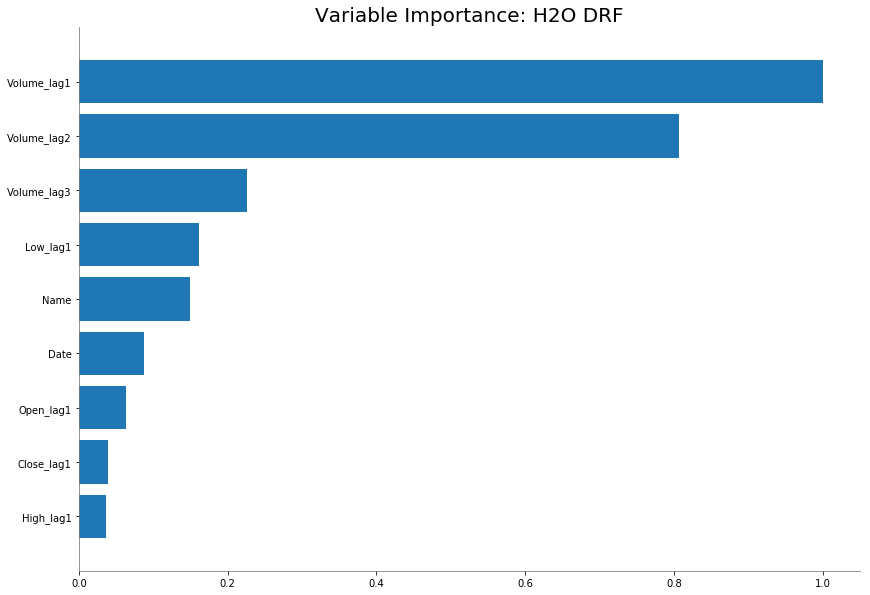

In [15]:
%matplotlib inline
drf_model.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


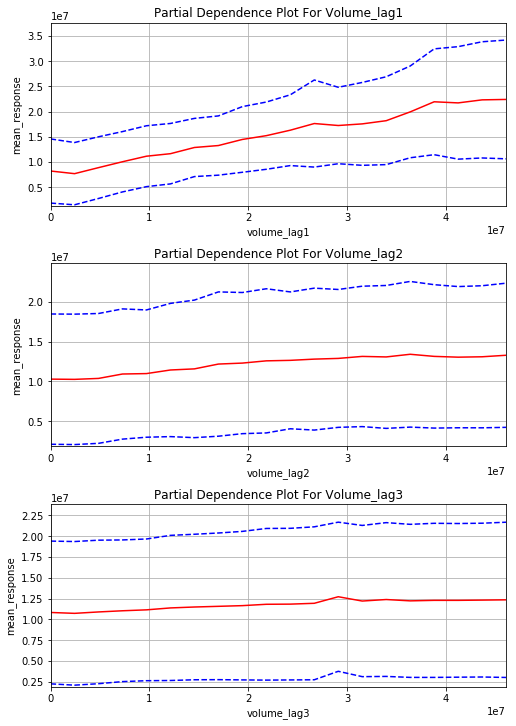

In [16]:
# Filter data to common volume
max_volume = train["Volume"].quantile(prob = [0.9])[0, 1]
pdp_data = train[(train["Volume_lag1"] < max_volume) & 
                 (train["Volume_lag2"] < max_volume) & 
                 (train["Volume_lag3"] < max_volume) ]
# create pdp's
pdps = drf_model.partial_plot(data = pdp_data, cols = ["Volume_lag1", "Volume_lag2", "Volume_lag3"])

The partial plots show that the Volume is directly related to the Volume values from the previous days for the company.

## AutoML in Flow

Now we can try running AutoML in Flow to see if we can improve the results even further.

In [17]:
print("Train ID: " + train.frame_id)
print("Test ID: " + test.frame_id)

Train ID: py_7_sid_a8aa
Test ID: py_8_sid_a8aa


To use AutoML select the AutoML option in the Model menu.

![menu](automl_menu.png)

Then we can provide AutoML with the training dataset, the response, and any columns that should be ignored.  
![problem](automl_problem.png)

Lastly, we will add the test data as our leaderboard data and set AutoML to run for 2 minutes.  We will exclude the DRF/Random Forest algorithm since we already tried that algorithm earlier.
![params](automl_params.png)

An example of the leaderboard is shown below:
![leaderboard](automl_leaderboard.png)

In [18]:
from h2o.automl.autoh2o import get_automl

leaderboard = get_automl("stock_forecast")

In [19]:
leaderboard.get("leaderboard")

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_grid_0_AutoML_20180626_175421_model_6,2.54534e+12,1.59541e+06,2.54534e+12,986222,0.21599
GBM_grid_0_AutoML_20180626_175421_model_4,5.24155e+12,2.28944e+06,5.24155e+12,1.15614e+06,0.162926
GBM_grid_0_AutoML_20180626_175421_model_0,6.69301e+12,2.58708e+06,6.69301e+12,1.1851e+06,0.22822
GBM_grid_0_AutoML_20180626_175421_model_3,7.7252e+12,2.77942e+06,7.7252e+12,1.17048e+06,0.176806
GBM_grid_0_AutoML_20180626_175421_model_1,9.10134e+12,3.01684e+06,9.10134e+12,1.31116e+06,0.204362
GBM_grid_0_AutoML_20180626_175421_model_2,9.92552e+12,3.15048e+06,9.92552e+12,1.30492e+06,0.193127
GBM_grid_0_AutoML_20180626_175421_model_7,1.10418e+13,3.32291e+06,1.10418e+13,1.61866e+06,0.25217
DeepLearning_0_AutoML_20180626_175421,2.27534e+13,4.77005e+06,2.27534e+13,2.9624e+06,nan
GBM_grid_0_AutoML_20180626_175421_model_8,2.69459e+14,1.64152e+07,2.69459e+14,1.41578e+07,1.63765
StackedEnsemble_AllModels_0_AutoML_20180626_175421,3.14123e+14,1.77235e+07,3.14123e+14,1.54023e+07,1.70008
